In [ ]:
import numpy  as np
import random
import math
import os

# Function: Initialize Variables
def initial_position(swarm_size, min_values, max_values, target_function):
    position  = np.zeros((swarm_size, len(min_values) + 1))
    velocity  = np.zeros((swarm_size, len(min_values)))
    frequency = np.zeros((swarm_size, 1))
    rate      = np.zeros((swarm_size, 1))
    loudness  = np.zeros((swarm_size, 1))
    for i in range(0, swarm_size):
        for j in range(0, len(min_values)):
             position[i,j] = random.uniform(min_values[j], max_values[j]) 
        position[i, -1] = target_function(position[i,0:position.shape[1]-1])
        rate[i, 0]      = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        loudness[i, 0]  = random.uniform(1, 2)
    return position, velocity, frequency, rate, loudness

############################################################################

# Function: Updtade Position
def update_position(position, velocity, frequency, rate, loudness, best_ind, alpha, gama, fmin, fmax, count, min_values, max_values, target_function):
    position_temp = np.zeros((position.shape[0], position.shape[1]))
    for i in range(0, position.shape[0]):
        beta           = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        frequency[i,0] = fmin + (fmax - fmin)*beta
        for j in range(0, len(max_values)):
            velocity[i, j] = velocity[i,j] + (position[i,j] - best_ind[j])*frequency[i,0]
        for k in range(0, len(max_values)):
            position_temp[i,k] = position[i,k] + velocity[i,k]
            if (position_temp[i,k] > max_values[k]):
                position_temp[i,k] = max_values[k]
                velocity[i,k]      = 0
            elif(position_temp[i,k] < min_values[k]):
                position_temp[i,k] = min_values[k]
                velocity[i,k]      = 0
        position_temp[i,-1] = target_function(position_temp[i,0:len(max_values)])
        rand                = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        if (rand > rate[i,0]):
            for L in range(0, len(max_values)):
                position_temp[i,L] = best_ind[L] + random.uniform(-1, 1)*loudness.mean()
                if (position_temp[i,L] > max_values[L]):
                    position_temp[i,L] = max_values[L]
                    velocity[i,L]      = 0
                elif(position_temp[i,L] < min_values[L]):
                    position_temp[i,L] = min_values[L]
                    velocity[i,L]      = 0
            position_temp[i,-1] = target_function(position_temp[i,0:len(max_values)])
        rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        if (rand < position[i,-1] and position_temp[i,-1] <= position[i,-1]):
            for m in range(0, len(max_values)):
                position[i, m] = position_temp[i, m]
            position[i,-1] = target_function(position[i,0:len(max_values)])
            rate[i,0]      = rate[i,0]*(1 - math.exp(-gama*count))
            loudness[i,0]  = alpha*loudness[i,-1]
        value = np.copy(position[position[:,-1].argsort()][0,:])
        if(best_ind[-1] > value[-1]):
            best_ind = np.copy(value)
    return position, velocity, frequency, rate, loudness, best_ind

############################################################################

# BA Function
def bat_algorithm(swarm_size, min_values, max_values, iterations, alpha, gama, fmin, fmax, target_function, verbose = True):    
    count                                         = 0
    position, velocity, frequency, rate, loudness = initial_position(swarm_size, min_values, max_values, target_function)
    best_ind                                      = np.copy(position[position[:,-1].argsort()][0,:])
    while (count <= iterations):
        if (verbose == True):
            print('Iteration = ', count, ' f(x) = ', best_ind[-1])       
        position, velocity, frequency, rate, loudness, best_ind = update_position(position, velocity, frequency, rate, loudness, best_ind, alpha, gama, fmin, fmax, count, min_values, max_values, target_function)
        count                                                   = count + 1        
    return best_ind

############################################################################

In [ ]:
# BA - Parameters
import math
import numpy as np
import matplotlib.pyplot as plt
parameters = {
    'swarm_size': 7500,
    'min_values': (1, 1),
    'max_values': (100, 200),
    'iterations': 50,
    'alpha': 0.8,
    'gama': 0.8,
    'fmin': 0,
    'fmax': 2,
    'verbose': True
}

In [ ]:
length_interconnect = np.linspace(1000,4000,10)
res=[]
for length in length_interconnect:
  def Timedelay_function_Copper_13nm(x,l=length):
        R_Cu = 242.4
        L_Cu = 2.13e-12  
        C_Cu = 0.037842e-15
        R_t = (R_Cu*l)/x[1]
        C_t = (C_Cu*l)/x[1]
        R_d0 = 30.3e3
        R_T = R_d0/(x[0]*R_t)
        C_d0 = 0.22e-15
        C_l0 = 0.15e-15
        C_T = (x[0]*C_l0)/C_t
        ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
        T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
        return x[1]*T_s
  ba = bat_algorithm(target_function = Timedelay_function_Copper_13nm, **parameters)
  variables = ba[:-1]
  minimum   = ba[ -1]
  res.append(np.around(variables, 4))
print(res)
length=[length_interconnect[i] for i in range(len(length_interconnect))]
optimal_repeater_size_13nm_ba_vs_length=[res[i][0] for i in range(len(res))]
optimal_repeater_number_13nm_ba_vs_length=[res[i][1] for i in range(len(res))]
#Cu_13nm
R_Cu = 242.4
L_Cu = 2.13e-12
C_Cu = 0.037842e-15
Rd = 30.3e3
C_d = 0.22e-15
Cl = 0.15e-15   
TL_R=math.sqrt(L_Cu/(R_Cu*Rd*(C_d + Cl)))
#Cu_13nm output for repeater size
repeater_size_computed_Cu_13nm_vs_length = math.sqrt((Rd*C_Cu)/(R_Cu*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
print(repeater_size_computed_Cu_13nm_vs_length)
x = (1+(0.18*((TL_R)**3)))**(0.3)
optimal_Cu_computed_13nm_vs_length = []
#Cu_13nm output for repeater number
for i in length_interconnect:
    optimal_Cu_computed_13nm_vs_length.append(math.ceil(i*(math.sqrt((R_Cu*C_Cu)/(2*Rd*(C_d + Cl)))*(1/x))))
plt.figure()
plt.title('Cu_13nm')
plt.scatter(length,optimal_Cu_computed_13nm_vs_length,color ='green',label='Actual value of Cu 13nm')
plt.plot(length,optimal_repeater_number_13nm_ba_vs_length,color = 'orange',label = 'Cu 13nm BA line')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.plot()

Iteration =  0  f(x) =  6.389987283552273e-10
Iteration =  1  f(x) =  6.389987283552273e-10
Iteration =  2  f(x) =  6.389987283552273e-10
Iteration =  3  f(x) =  6.389987283552273e-10
Iteration =  4  f(x) =  6.389987283552273e-10
Iteration =  5  f(x) =  6.389987283552273e-10
Iteration =  6  f(x) =  6.389987283552273e-10
Iteration =  7  f(x) =  6.389987283552273e-10
Iteration =  8  f(x) =  6.389987283552273e-10
Iteration =  9  f(x) =  6.389987283552273e-10
Iteration =  10  f(x) =  6.389987283552273e-10
Iteration =  11  f(x) =  6.389987283552273e-10
Iteration =  12  f(x) =  6.389987283552273e-10
Iteration =  13  f(x) =  6.389987283552273e-10
Iteration =  14  f(x) =  6.389987283552273e-10
Iteration =  15  f(x) =  6.389987283552273e-10
Iteration =  16  f(x) =  6.389987283552273e-10
Iteration =  17  f(x) =  6.389987283552273e-10
Iteration =  18  f(x) =  6.389987283552273e-10
Iteration =  19  f(x) =  6.389987283552273e-10
Iteration =  20  f(x) =  6.389987283552273e-10
Iteration =  21  f(x) =

Iteration =  0  f(x) =  1.352173821288423e-09
Iteration =  1  f(x) =  1.352173821288423e-09
Iteration =  2  f(x) =  1.352173821288423e-09
Iteration =  3  f(x) =  1.352173821288423e-09
Iteration =  4  f(x) =  1.352173821288423e-09
Iteration =  5  f(x) =  1.352173821288423e-09
Iteration =  0  f(x) =  1.799467339268975e-09
Iteration =  1  f(x) =  1.799467339268975e-09
Iteration =  2  f(x) =  1.799467339268975e-09
Iteration =  3  f(x) =  1.799467339268975e-09
Iteration =  4  f(x) =  1.799467339268975e-09
Iteration =  5  f(x) =  1.799467339268975e-09
Iteration =  0  f(x) =  2.250565200280587e-09
Iteration =  1  f(x) =  2.250565200280587e-09
Iteration =  2  f(x) =  2.250565200280587e-09
Iteration =  3  f(x) =  2.250565200280587e-09
Iteration =  4  f(x) =  2.250565200280587e-09
Iteration =  5  f(x) =  2.250565200280587e-09
Iteration =  0  f(x) =  2.698857088976876e-09
Iteration =  1  f(x) =  2.698857088976876e-09
Iteration =  2  f(x) =  2.698857088976876e-09
Iteration =  3  f(x) =  2.69885708

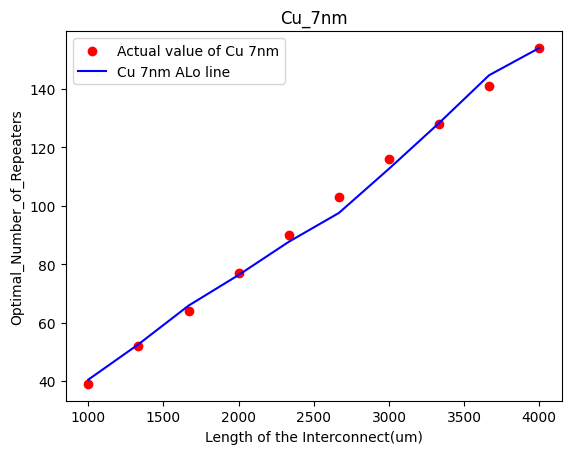

In [ ]:
res=[]
for length in length_interconnect:
  def Timedelay_function_Copper_7nm(x,l=length):
        R_Cu = 1226.7
        L_Cu = 2.24e-12
        C_Cu = 0.03177e-15
        R_t = (R_Cu*l)/x[1]
        C_t = (C_Cu*l)/x[1]
        R_d0 = 69.7e3
        R_T = R_d0/(x[0]*R_t)
        C_d0 = 0.13e-15
        C_l0 = 0.06e-15
        C_T = (x[0]*C_l0)/C_t
        ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
        T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
        return x[1]*T_s
  ba = bat_algorithm(target_function = Timedelay_function_Copper_7nm, **parameters)
  variables = ba[:-1]
  minimum   = ba[ -1]
  res.append(np.around(variables, 4))
print(res)
length=[length_interconnect[i] for i in range(len(length_interconnect))]
optimal_repeater_size_7nm_ba_vs_length=[res[i][0] for i in range(len(res))]
optimal_repeater_number_7nm_ba_vs_length=[res[i][1] for i in range(len(res))]
#Cu_7nm
R_Cu = 1226.7
L_Cu = 2.24e-12
C_Cu = 0.03177e-15
Rd = 69.7e3
C_d = 0.13e-15
Cl = 0.06e-15
Cdl = C_d+Cl
TL_R=math.sqrt(L_Cu/(R_Cu*Rd*Cdl))
#Cu_7nm output for repeater size
repeater_size_computed_Cu_7nm_vs_length = math.sqrt((Rd*C_Cu)/(R_Cu*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
print(repeater_size_computed_Cu_7nm_vs_length)
x = (1+(0.18*((TL_R)**3)))**(0.3)
optimal_Cu_computed_7nm_vs_length = []
#Cu_7nm output for repeater number
for i in length_interconnect:
    optimal_Cu_computed_7nm_vs_length.append(math.ceil(i*(math.sqrt((R_Cu*C_Cu)/(2*Rd*(Cdl)))*(1/x))))
plt.figure()
plt.title('Cu_7nm')
plt.scatter(length,optimal_Cu_computed_7nm_vs_length,color ='red',label='Actual value of Cu 7nm')
plt.plot(length,optimal_repeater_number_7nm_ba_vs_length,color = 'blue',label = 'Cu 7nm ALo line')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()

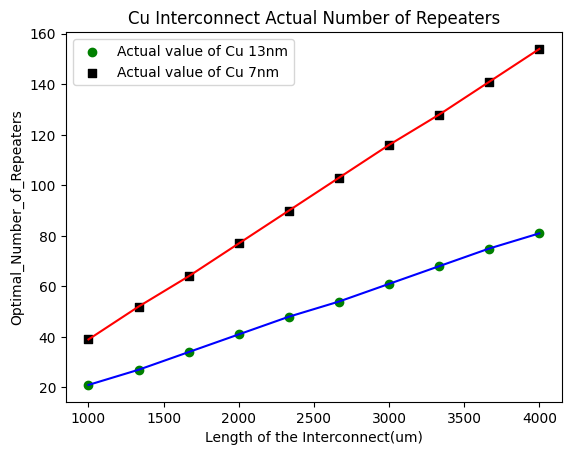

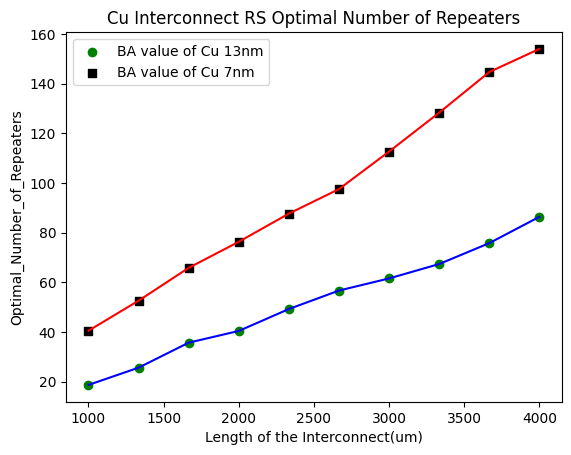

In [ ]:
plt.scatter(length,optimal_Cu_computed_13nm_vs_length,color ='green',label='Actual value of Cu 13nm')
plt.plot(length,optimal_Cu_computed_13nm_vs_length,color ='blue')
plt.scatter(length_interconnect,optimal_Cu_computed_7nm_vs_length,color ='black',label='Actual value of Cu 7nm',marker="s")
plt.plot(length_interconnect,optimal_Cu_computed_7nm_vs_length,color ='red')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.title('Cu Interconnect Actual Number of Repeaters')
plt.show()
plt.scatter(length,optimal_repeater_number_13nm_ba_vs_length,color ='green',label='BA value of Cu 13nm')
plt.plot(length,optimal_repeater_number_13nm_ba_vs_length,color ='blue')
plt.scatter(length_interconnect,optimal_repeater_number_7nm_ba_vs_length,color ='black',label='BA value of Cu 7nm',marker="s")
plt.plot(length_interconnect,optimal_repeater_number_7nm_ba_vs_length,color ='red')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.title('Cu Interconnect RS Optimal Number of Repeaters')
plt.show()

In [ ]:
import math
AR= 2.34
C=1.2
lambda_Cu=37.3e-9
R_g=0.4
W_Cu=13e-9
d_g=W_Cu
rho_0=2.04e-8
p=list(range(1,101))
p_Cu_list=[0.01*ele for ele in p]
z_res=[]
for p_req in p_Cu_list:
  z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
  z_res.append(z)
print(z_res)
alpha=((lambda_Cu*R_g)/(1-R_g))*(1.0/d_g)
y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))
print(alpha)
final_rho= [rho_0*(y+z_r) for z_r in z_res]
R_pul=[(final_rho[i])*1e-6/(W_Cu*W_Cu*AR) for i in range(len(final_rho))]
print(R_pul)
L_Cu = 2.13e-12
C_Cu = 0.037842e-15
R_Cu=R_pul
Rd = 30.3e3

C_d = 0.22e-15
Cl = 0.15e-15
C_d1 = C_d + Cl  
TL_R=[math.sqrt(L_Cu/(R_pul[i]*Rd*(C_d + Cl))) for i in range(len(R_pul))]
#Cu_13nm output for repeater size
repeater_size_computed_Cu_13nm_vs_p = [math.sqrt((Rd*C_Cu)/(R_pul[i]*Cl))*(1/((1+(0.18*((TL_R[i])**3)))**(0.26)))for i in range(len(TL_R))]

[1.824499704142012, 1.8060704142011832, 1.7876411242603547, 1.7692118343195264, 1.750782544378698, 1.7323532544378697, 1.7139239644970412, 1.695494674556213, 1.6770653846153847, 1.6586360946745562, 1.6402068047337275, 1.6217775147928994, 1.6033482248520707, 1.5849189349112425, 1.566489644970414, 1.5480603550295857, 1.5296310650887572, 1.511201775147929, 1.4927724852071007, 1.4743431952662722, 1.4559139053254437, 1.4374846153846155, 1.419055325443787, 1.4006260355029585, 1.38219674556213, 1.3637674556213017, 1.3453381656804733, 1.3269088757396448, 1.3084795857988165, 1.290050295857988, 1.2716210059171595, 1.253191715976331, 1.2347624260355028, 1.2163331360946743, 1.197903846153846, 1.1794745562130178, 1.1610452662721893, 1.142615976331361, 1.1241866863905323, 1.105757396449704, 1.0873281065088756, 1.0688988165680473, 1.050469526627219, 1.0320402366863906, 1.013610946745562, 0.9951816568047338, 0.9767523668639054, 0.9583230769230768, 0.9398937869822485, 0.9214644970414201, 0.903035207100

[5.225145012633847, 5.234038726719293, 5.242978009860421, 5.251963252530745, 5.26099484990415, 5.270073201927886, 5.279198713396968, 5.288371794029979, 5.297592858546339, 5.306862326745048, 5.316180623584976, 5.325548179266673, 5.334965429315802, 5.344432814668184, 5.353950781756513, 5.363519782598775, 5.373140274888416, 5.382812722086289, 5.39253759351443, 5.40231536445171, 5.412146516231395, 5.422031536340663, 5.431970918522148, 5.441965162877504, 5.452014775973115, 5.462120270947919, 5.472282167623467, 5.482500992616237, 5.492777279452252, 5.5031115686840835, 5.513504408010282, 5.523956352397291, 5.534467964203927, 5.5450398133084535, 5.555672477238364, 5.566366541302883, 5.577122598728309, 5.58794125079623, 5.598823106984696, 5.609768785112451, 5.620778911486252, 5.631854121051396, 5.642995057545516, 5.65420237365574, 5.665476731179308, 5.6768188011876966, 5.6882292641943994, 5.699708810326428, 5.711258139499624, 5.722877961597905, 5.73456899665653, 5.746331975049511, 5.75816763768

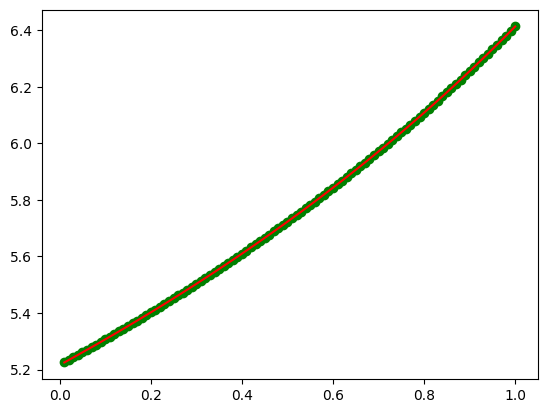

In [ ]:
import matplotlib.pyplot as plt
print(repeater_size_computed_Cu_13nm_vs_p)
plt.scatter(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color='green')
plt.plot(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color='red')

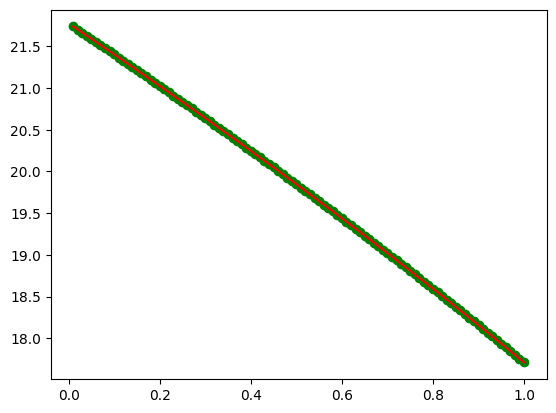

In [ ]:
optimal_Cu_computed_13nm_vs_p=[1000*(math.sqrt((R_pul[k]*C_Cu)/(2*Rd*(C_d+Cl)))*(1/(1+(0.18*((TL_R[k])**3)))**(0.3))) for k in range(len(R_pul))]
import matplotlib.pyplot as plt
plt.scatter(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color='green')
plt.plot(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color='red')

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
# BA - Parameters
parameters = {
    'swarm_size': 7500,
    'min_values': (1, 1),
    'max_values': (100, 200),
    'iterations': 5,
    'alpha': 0.8,
    'gama': 0.8,
    'fmin': 0,
    'fmax': 2,
    'verbose': True
}
res=[]
for p in p_Cu_list:
  def Timedelay_function_Copper_13nm_p_req(x,p_req=p):
        l=1000
        lambda_Cu=37.3e-9
        R_g=0.4
        W_Cu=13e-9
        d_g=W_Cu
        AR=2.34
        C=1.2
        rho_0=2.04e-8
        # p_req=1.0
        L_Cu = 2.13e-12  
        C_Cu = 0.037842e-15
        # p_req=p_req
        alpha=((lambda_Cu*R_g)/((1-R_g)*(d_g)))
        y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))
        z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
        res_list = rho_0*(y+z)
        R_pul=(res_list)*1e-6/(W_Cu*W_Cu*AR)
        R_Cu=R_pul
        print(R_Cu)
        R_t = (R_Cu*l)/x[1]
        C_t = (C_Cu*l)/x[1]
        R_d0 = 30.3e3
        R_T = R_d0/(x[0]*R_t)
        C_d0 = 0.22e-15
        C_l0 = 0.15e-15
        C_T = (x[0]*C_l0)/C_t
        TL_R=math.sqrt(L_Cu/(R_pul*Rd*(C_d + Cl)))
        x[0]=math.sqrt((Rd*C_Cu)/(R_pul*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
        x[1]=(1000*(math.sqrt((R_pul*C_Cu)/(2*Rd*(C_d0+C_l0)))*(1/(1+(0.18*((TL_R)**3)))**(0.3))))
        ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
        T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
        return x[1]*T_s
  ba = bat_algorithm(target_function = Timedelay_function_Copper_13nm_p_req, **parameters)
  variables = ba[:-1]
  minimum   = ba[ -1]
  res.append(np.around(variables, 4))
  print(res)

Streaming output truncated to the last 5000 lines.
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004
214.38346278591004

In [ ]:
optimal_repeater_size_13nm_pso_vs_p=[res[i][0] for i in range(len(res))]
optimal_repeater_number_13nm_pso_vs_p=[res[i][1] for i in range(len(res))]

#Calculation for 7nm

In [ ]:
lambda_Cu=37.3e-9
import numpy as np
R_g=0.4

In [ ]:
W_Cu=7e-9
d_g=W_Cu
alpha=((lambda_Cu*R_g)/(1-R_g))*(1.0/d_g)
#alpha=(lambda_Cu* R_g)/(d_g*(1-R_g))
print(alpha)
import math

In [ ]:
AR=2.4
C=1.2
p_Cu=0.41
rho_0=2.04e-8

In [ ]:
alpha
y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))

In [ ]:
p=list(range(1,101))
p_Cu_list=[0.01*ele for ele in p]
z_res=[]
for p_req in p_Cu_list:
  z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
  z_res.append(z)
print(z_res)

In [ ]:
final_rho= [rho_0*(y+z_r) for z_r in z_res]

In [ ]:
R_pul=[(final_rho[i])*1e-6/(W_Cu*W_Cu*AR) for i in range(len(final_rho))]
print(R_pul)
R_Cu = 1352.7
L_Cu = 2.24e-12
C_Cu = 0.03177e-15
Rd = 69.7e3
C_d = 0.13e-15
Cl = 0.06e-15

In [ ]:
TL_R=[math.sqrt(L_Cu/(R_pul[i]*Rd*(C_d + Cl))) for i in range(len(R_pul))]
#Cu_7nm output for repeater size
repeater_size_computed_Cu_7nm_vs_p = [math.sqrt((Rd*C_Cu)/(R_pul[i]*Cl))*(1/((1+(0.18*((TL_R[i])**3)))**(0.26)))for i in range(len(TL_R))]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color='green')
plt.plot(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color='red')

In [ ]:
optimal_Cu_computed_7nm_vs_p=[1000*(math.sqrt((R_pul[k]*C_Cu)/(2*Rd*(C_d+Cl)))*(1/(1+(0.18*((TL_R[k])**3)))**(0.3))) for k in range(len(R_pul))]

In [ ]:
optimal_Cu_computed_7nm_vs_p

In [ ]:
plt.figure()
#plt.subplot(2,2,1)
plt.title('Cu_7nm')
plt.scatter(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='red',label='Actual value of Cu 7nm')
plt.plot(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='blue')
#plt.plot(length_interconnect,Opt_Rep_Number_Cu_7nm,color = 'blue',label = 'Cu 7nm PSO line')
plt.xlabel('p')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.show()

In [ ]:
plt.scatter(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color ='green',label='Actual value of Cu 13nm')
plt.plot(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color ='blue')
plt.scatter(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color ='black',label='Actual value of Cu 7nm',marker="s")
plt.plot(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color ='red')
plt.xlabel('p')
plt.ylabel('Repeaters Size')
plt.legend()
plt.title('Cu Interconnect Repeaters Size')
plt.show()

In [ ]:
plt.scatter(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color ='green',label='Actual value of Cu 13nm')
plt.plot(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color ='blue')
plt.scatter(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='black',label='Actual value of Cu 7nm',marker="s")
plt.plot(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='red')
plt.xlabel('p')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.title('Cu Interconnect Optimal Number of Repeaters')
plt.show()